I want to make a supervised training of the neural network using the equinox framework so i can rule out the possibility of the DeepXDE framework
be failling to converge because some internal detail i'm not aware of.

In [74]:
import fluidfoam
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt

# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
jax.config.update("jax_default_matmul_precision", "float32")

In [2]:
jax.local_devices()

[CudaDevice(id=0), CudaDevice(id=1)]

# Loading training dataset

In [36]:
case = "../../tests/vizualizing_simulation_data/bernard_cell_of_v2/"

x, y, z = jnp.array(fluidfoam.readmesh(case))

u, v, w = jnp.array(fluidfoam.readfield(case, "1000", "U"), dtype=jnp.float32)
T = jnp.array(fluidfoam.readscalar(case, "1000", "T"), dtype=jnp.float32)
p = jnp.array(fluidfoam.readscalar(case, "1000", "p"), dtype=jnp.float32)

Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/owner
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/faces
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/points
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2//constant/polyMesh/neighbour
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2/1000/U
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2/1000/T
Reading file ../../tests/vizualizing_simulation_data/bernard_cell_of_v2/1000/p


In [49]:
N = T.shape[0]
N

idx_key = jax.random.key(100)
idx = jax.random.choice(idx_key, N, shape=(10000,), replace=False)

N

40000

In [55]:
X = jnp.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])[idx]
Y = jnp.hstack([f.reshape(-1, 1) for f in [u, v, p, T]])[idx]

In [57]:
jax.vmap(model)(X)

Array([[ 0.00915568,  0.00749173, -0.00557074,  0.2350281 ],
       [ 0.0091607 ,  0.00749366, -0.00553908,  0.23500976],
       [ 0.0091526 ,  0.0074914 , -0.00555928,  0.23502338],
       ...,
       [ 0.0091216 ,  0.00749499, -0.00553294,  0.23500189],
       [ 0.0091394 ,  0.00749345, -0.00553121,  0.2349972 ],
       [ 0.00911577,  0.00749589, -0.00552208,  0.23499247]],      dtype=float32)

# Defining model

In [60]:
LAYERS = [2] + 6*[256] + [4]

class MLP(eqx.Module):
    layers: list[eqx.nn.Linear]

    def __init__(self, layer_sizes, key):

        self.layers = []

        for (size_in, size_out) in zip(layer_sizes[:-1], layer_sizes[1:]):
            
            key, subkey = jax.random.split(key)  # Make sure initialization is reproducible
            
            self.layers.append(
                eqx.nn.Linear(
                    size_in, 
                    size_out,
                    use_bias=True,
                    key=subkey
            ))

        
    def __call__(self, x):           
        a = x
        
        for layer in self.layers[:-1]:
            a = jax.nn.silu(layer(a))

        return self.layers[-1](a)
            
     

In [61]:
def loss_fm(model, x, y):
    out  = jax.vmap(model)(x)
    delta = (y - out)**2
    return jnp.mean(delta)

# loss_val_and_grad = jax.value_and_grad(loss)

# Sometimes equinox models can get very complex and include modules that are not jax compatible. In these
# cases we need to use filtering capabilities of equinox.

loss_val_and_grad = eqx.filter_value_and_grad(loss_fm)

In [77]:
key = jax.random.key(42)

model = MLP(LAYERS, key) 
losses = []

opt = optax.sgd(0.0001)
opt_state = opt.init(eqx.filter(model, eqx.is_array))

@jax.jit
def make_step(m, opt_s, x, y):
    loss, grad = loss_val_and_grad(m, x, y)
    updates, opt_s = opt.update(grad, opt_s, m)
    m = eqx.apply_updates(m, updates)

    return m, opt_s, loss


In [9]:
jax.config.update("jax_debug_nans", True)

In [83]:

# Training Loop

for epoch in range(100_000):
    model, opt_state, loss = make_step(model, opt_state, X, Y)

    # if not jax.numpy.isnan( loss.item() ):
    #     print(f"{epoch = } | loss = {losses[-1]}")
    #     break
    
    if epoch % 1000 == 0:  
        losses.append(loss)
        print(f"{epoch = } | loss = {losses[-1]}")
        

    

epoch = 0 | loss = 0.029632704332470894
epoch = 1000 | loss = 0.02914752997457981
epoch = 2000 | loss = 0.028720391914248466
epoch = 3000 | loss = 0.028343750163912773
epoch = 4000 | loss = 0.028011567890644073
epoch = 5000 | loss = 0.02771882526576519
epoch = 6000 | loss = 0.02746051549911499
epoch = 7000 | loss = 0.027233125641942024
epoch = 8000 | loss = 0.02703251875936985
epoch = 9000 | loss = 0.026855435222387314
epoch = 10000 | loss = 0.026699410751461983
epoch = 11000 | loss = 0.02656184695661068
epoch = 12000 | loss = 0.026440653949975967
epoch = 13000 | loss = 0.02633371576666832
epoch = 14000 | loss = 0.02623947709798813
epoch = 15000 | loss = 0.026156358420848846
epoch = 16000 | loss = 0.026083312928676605
epoch = 17000 | loss = 0.026018895208835602
epoch = 18000 | loss = 0.025962112471461296
epoch = 19000 | loss = 0.025912107899785042
epoch = 20000 | loss = 0.025868026539683342
epoch = 21000 | loss = 0.025829220190644264
epoch = 22000 | loss = 0.025795042514801025
epoch = 

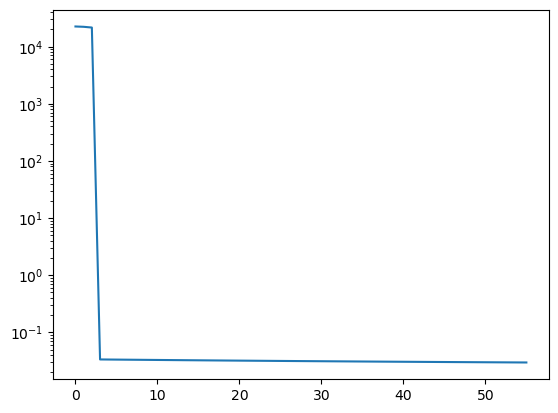

In [79]:
plt.plot(losses)
plt.yscale("log")

In [80]:
u_out, v_out, p_out, T_out = jax.vmap(model)(X).T

In [76]:
u_out

Array([1.35580078e-04, 4.68287617e-05, 1.09510496e-04, ...,
       1.00092962e-04, 6.54850155e-05, 8.44392926e-05], dtype=float32)

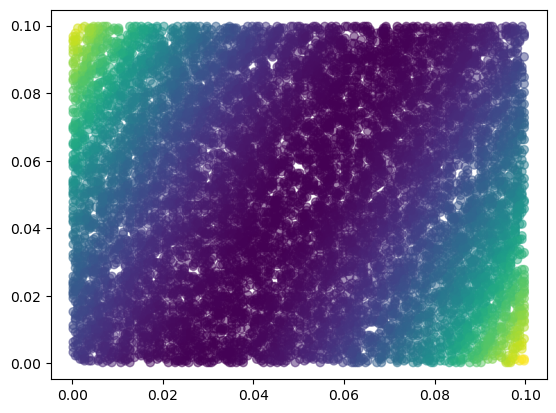

In [82]:
plt.scatter(x[idx], y[idx], c=u_out**2 + v_out**2, alpha=0.5)

In [73]:
u_out.mean(), u.mean()

(Array(-3.8265283e-05, dtype=float32), Array(5.8949807e-12, dtype=float32))

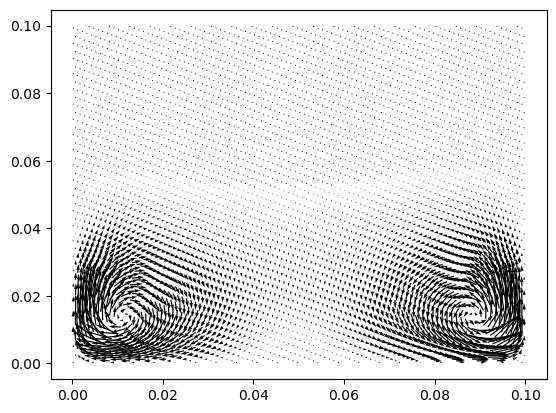

In [48]:
skip_ind = 9
plt.quiver(x[::skip_ind], y[::skip_ind], u[::skip_ind], v[::skip_ind])

In [ ]:
plt.quiver(x[idx], y[idx]

In [ ]:
type( loss.item() )

In [ ]:
jax.numpy.isnan( loss.item() )